Project root: c:\Users\zklu8\Documents\COMP 576\Portfolio-Allocator
log_returns shape: (3772, 4)
Train / Val / Test sizes: 2263 754 755

Baseline final values on VALIDATION period:
  Buy & Hold SPY final value:   2.0059
  Equal-weight final value:      1.3954

Training history head:


,episode,train_ep_return,val_final_value,steps
45,46,4.536782,1.331593,2243
46,47,4.874575,1.528155,2243
47,48,4.769723,0.979037,2243
48,49,5.462013,1.236632,2243
49,50,4.898092,1.045762,2243


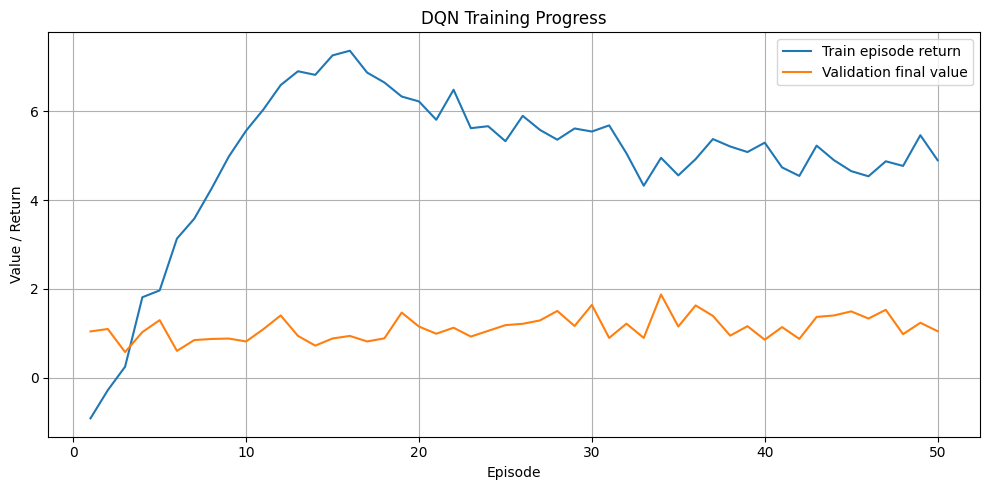

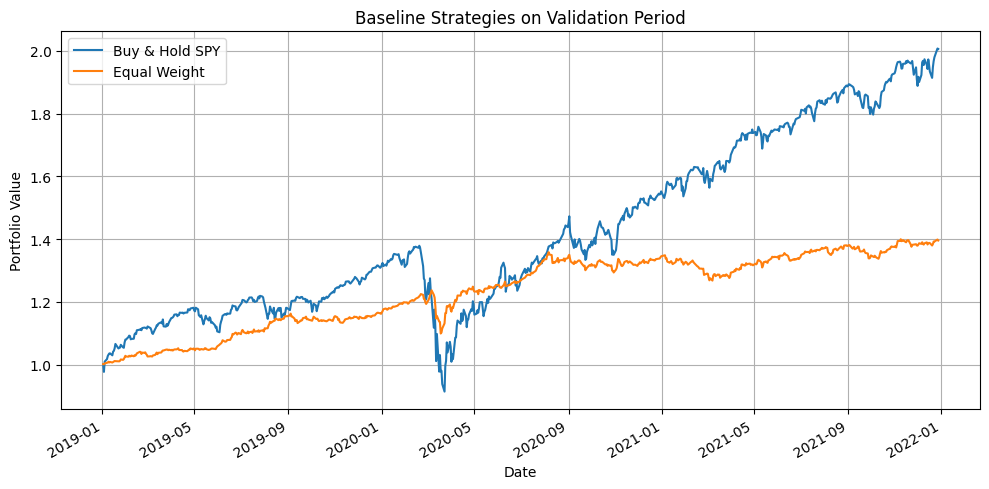

In [ ]:
# ---- 0. Make src importable from this notebook (src/notebooks) ----
import os
import sys

# We are in src/notebooks, so:
#   ".."   = src
#   "../.." = project root (contains src, data, results)
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
if project_root not in sys.path:
    sys.path.append(project_root)

print("Project root:", project_root)

# ---- 1. Imports ----
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.baselines import (
    run_backtest,
    buy_and_hold_spy_weights,
    equal_weight_weights,
)
from src.data_processing import train_val_test_split


# ---- 2. Load log returns and compute train/val/test splits ----

# From src/notebooks, data is two levels up
log_rets_path = Path(project_root) / "data" / "processed" / "log_returns.csv"
log_rets = pd.read_csv(log_rets_path, index_col=0, parse_dates=True)

print("log_returns shape:", log_rets.shape)

train_dates, val_dates, test_dates = train_val_test_split(log_rets.index)

log_rets_train = log_rets.loc[log_rets.index.isin(train_dates)].copy()
log_rets_val = log_rets.loc[log_rets.index.isin(val_dates)].copy()
log_rets_test = log_rets.loc[log_rets.index.isin(test_dates)].copy()

print("Train / Val / Test sizes:",
      len(log_rets_train), len(log_rets_val), len(log_rets_test))


# ---- 3. Run baseline strategies on the validation set ----

spy_curve_val = run_backtest(log_rets_val, buy_and_hold_spy_weights)
ew_curve_val = run_backtest(log_rets_val, equal_weight_weights)

print("\nBaseline final values on VALIDATION period:")
print(f"  Buy & Hold SPY final value:   {spy_curve_val.iloc[-1]:.4f}")
print(f"  Equal-weight final value:      {ew_curve_val.iloc[-1]:.4f}")


# ---- 4. Load DQN training history ----

hist_path = Path(project_root) / "results" / "training_stats.csv"
if not hist_path.exists():
    raise FileNotFoundError(
        f"{hist_path} not found. "
        "Run `python -m src.train_dqn` from the project root first."
    )

history = pd.read_csv(hist_path)
print("\nTraining history tail:")
display(history.tail())


# ---- 5. Plot DQN training progress ----

plt.figure(figsize=(10, 5))
plt.plot(history["episode"], history["train_ep_return"], label="Train episode return")
plt.plot(history["episode"], history["val_final_value"], label="Validation final value")

plt.xlabel("Episode")
plt.ylabel("Value / Return")
plt.title("DQN Training Progress")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# ---- 6. (Optional) Plot validation baseline curves ----

plt.figure(figsize=(10, 5))
spy_curve_val.plot(label="Buy & Hold SPY")
ew_curve_val.plot(label="Equal Weight")

plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.title("Baseline Strategies on Validation Period")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
